# ASL Alphabet Detection

## Data Analysis

In [1]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

2024-05-12 20:41:21.031600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 20:41:21.031715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 20:41:21.284299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)

    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        for img in imgs:
            img_path = os.path.join(f_path, img)


            filepaths.append(img_path)
            labels.append(fold)


    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')


    return pd.concat([fseries, lseries], axis=1)


df = create_dataframe(data)

In [3]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [4]:
target_size = (64, 64)
target_dims = (64, 64, 3)
n_classes = 29
val_frac = 0.1
batch_size = 64
epochs = 10

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


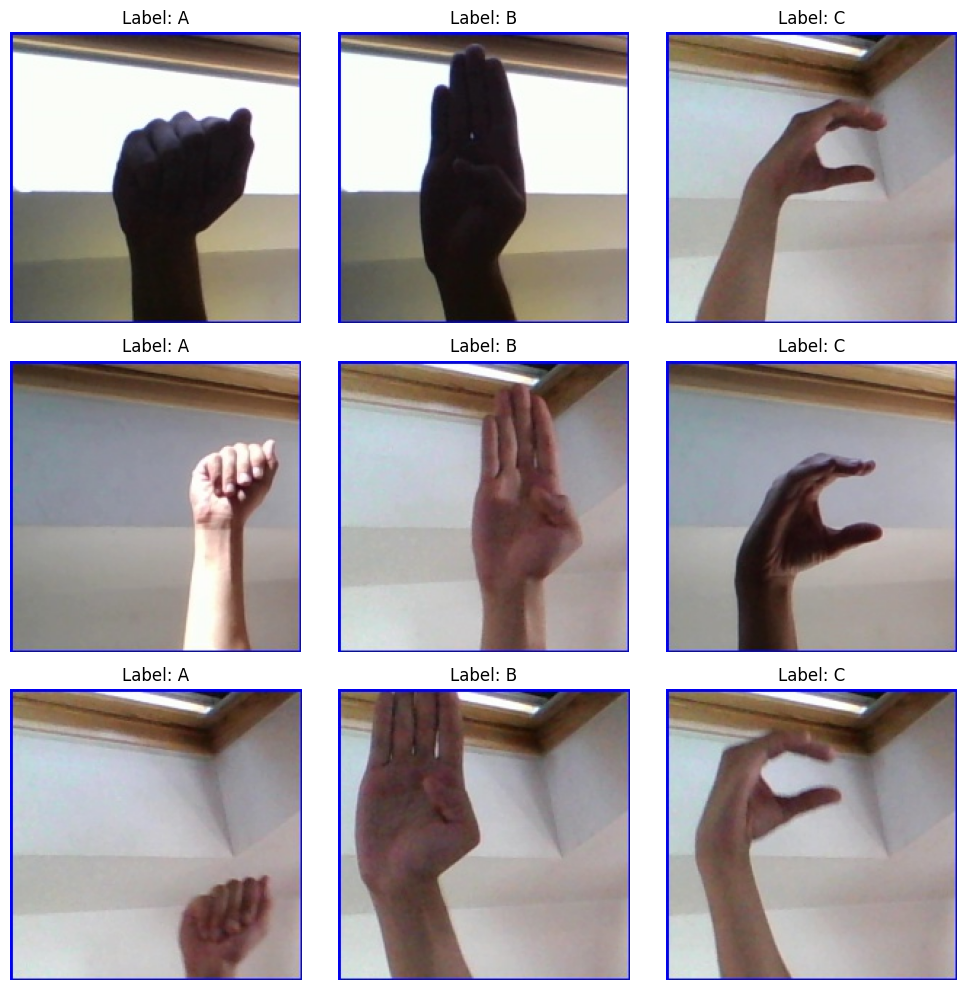

In [6]:
import random
import matplotlib.pyplot as plt
import pandas as pd

def plot_samples(df, labels, num_samples_per_label=3):
    plt.figure(figsize=(10, 10))
    for label_idx, label in enumerate(labels):
        label_df = df[df['Labels'] == label]
        
        rand_indices = random.sample(range(len(label_df)), min(num_samples_per_label, len(label_df)))
        
        for i, rand_idx in enumerate(rand_indices):
            img_path = label_df.iloc[rand_idx]['Filepaths']
            label = label_df.iloc[rand_idx]['Labels']
            
            img = plt.imread(img_path)
            plt.subplot(len(labels), num_samples_per_label, len(labels)*i + label_idx + 1)
            plt.imshow(img)
            plt.title(f'Label: {label}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

labels = ["A", "B", "C"]
plot_samples(train_df, labels)

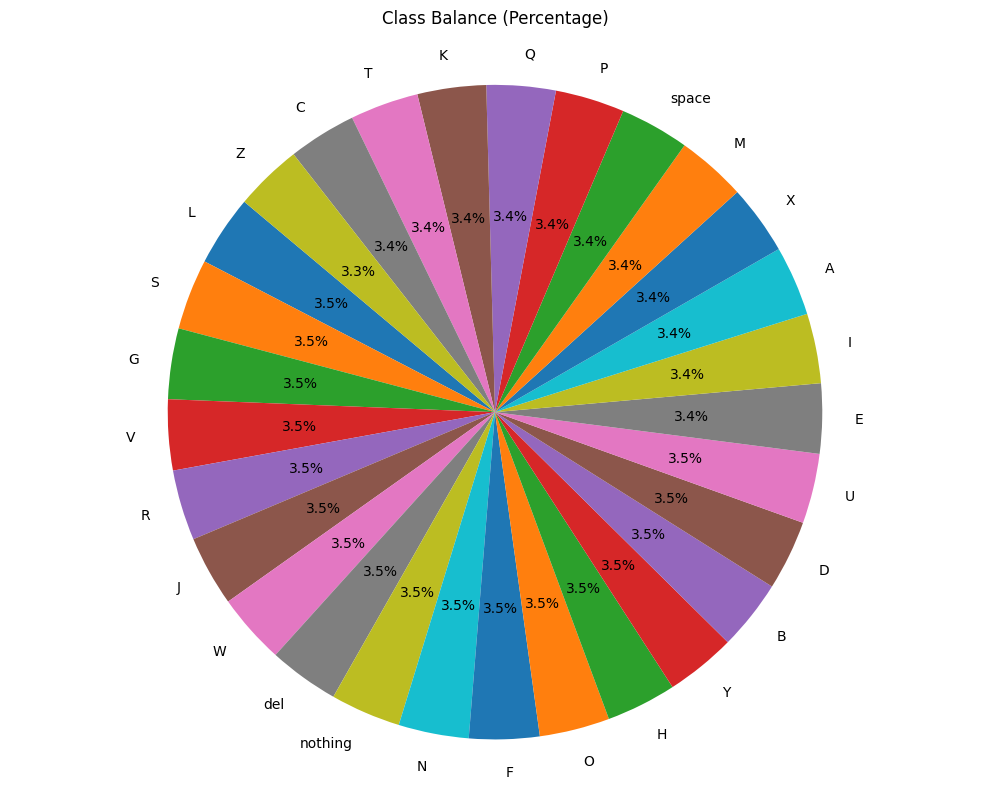

In [7]:
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

total_images = len(train_df)

class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

class_counts = class_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)\n')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Model Specification

In [21]:
inputs = tf.keras.Input(shape=target_dims)

# Depth-wise separable convolution block
def mobilenet_block(x, filters, strides):
    x = tf.keras.layers.DepthwiseConv2D((3, 3), strides=strides, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)

x = mobilenet_block(x, 64, (1, 1))
x = mobilenet_block(x, 128, (2, 2))
x = mobilenet_block(x, 128, (1, 1))
x = mobilenet_block(x, 256, (2, 2))
x = mobilenet_block(x, 256, (1, 1))
x = mobilenet_block(x, 512, (2, 2))

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam'
)

model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Model Train

In [23]:
best_model_path = "best_model.weights.h5"
save_best_model = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_loss', 
                                  save_best_only=True, save_weights_only=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[save_best_model],
)

model.load_weights(best_model_path)

Epoch 1/10
 352/1088 ━━━━━━━━━━━━━━━━━━━━ 4:42 384ms/step - accuracy: 0.1622 - loss: 2.8933

W0000 00:00:1715547363.789871     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 478s 437ms/step - accuracy: 0.3312 - loss: 2.2205 - val_accuracy: 0.4784 - val_loss: 1.9212
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 196s 180ms/step - accuracy: 0.8153 - loss: 0.5367 - val_accuracy: 0.8168 - val_loss: 0.6521
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 197s 180ms/step - accuracy: 0.8974 - loss: 0.2977 - val_accuracy: 0.8485 - val_loss: 0.5815
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 197s 180ms/step - accuracy: 0.9293 - loss: 0.2064 - val_accuracy: 0.9568 - val_loss: 0.1414
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 195s 178ms/step - accuracy: 0.9458 - loss: 0.1618 - val_accuracy: 0.9116 - val_loss: 0.3558
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 194s 178ms/step - accuracy: 0.9566 - loss: 0.1327 - val_accuracy: 0.9664 - val_loss: 0.0896
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 198s 181ms/step - accuracy: 0.9581 - loss: 0.1231 - val_accuracy: 0.9347 - val_loss: 0.2265
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 198s 181ms/step - accuracy: 0.9

## Model Test

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

136/136 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - accuracy: 0.9768 - loss: 0.0702
Test Accuracy: 0.9758620858192444


## Model Metrics

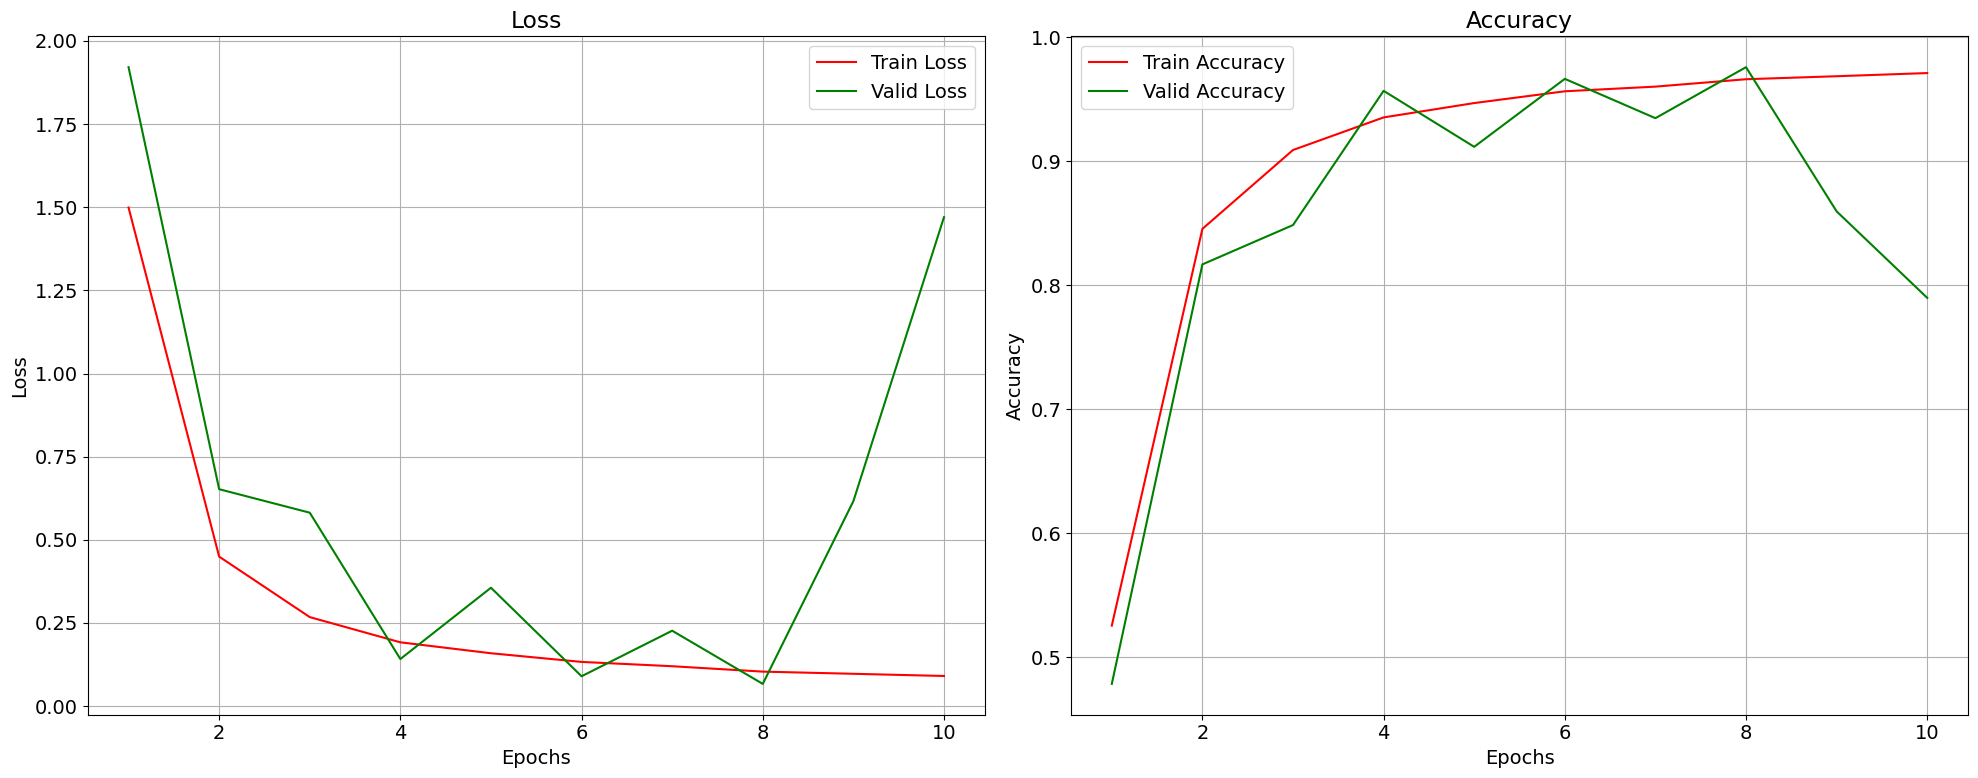

In [26]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})  # Set font size

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()